# Lab 01 : LeNet5 ChebGCNs - AXEL


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>
Advances in Neural Information Processing Systems, 3844-3852, 2016<br>
ArXiv preprint: [arXiv:1606.09375](https://arxiv.org/pdf/1606.09375.pdf) <br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import random
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import dgl
import networkx as nx
import matplotlib.pyplot as plt

#import collections
# MAC PROBLEM THAT MAKES THE NOTEBOOK Crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2

# MNIST

In [2]:
# Downloads the dataset if not found locally
from utils import check_mnist_dataset_exists
_ = check_mnist_dataset_exists()

In [3]:
nb_selected_train_data = 500
nb_selected_test_data = 100

train_data = torch.load('mnist/train_data.pt').reshape(60000, 784)
train_data = train_data[:nb_selected_train_data, :]
print(train_data.shape, type(train_data))

train_labels = torch.load('mnist/train_label.pt')
train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data = torch.load('mnist/test_data.pt').reshape(10000, 784)
test_data = test_data[:nb_selected_test_data, :]
print(test_data.shape)

test_labels = torch.load('mnist/test_label.pt')
test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

torch.Size([500, 784]) <class 'torch.Tensor'>
torch.Size([500])
torch.Size([100, 784])
torch.Size([100])


In [4]:
# Import the dataset from file
from dataset import MNISTDataset

In [5]:
trainset = MNISTDataset(train_data,train_labels)
testset = MNISTDataset(test_data,test_labels)

In [6]:
def showGraph(graph, label, signal = False):
    '''
    Function to visualise the signal of the handwritten digits over a lattice graph
    '''
    
    if signal is False: signal = graph.ndata['h'] 
    nx_G = graph.to_networkx().to_undirected()

    # Kamada-Kawaii layout
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=signal)
    plt.title('Class: {:d}'.format(label))
    plt.figure(figsize=(10,3))
    plt.show()

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


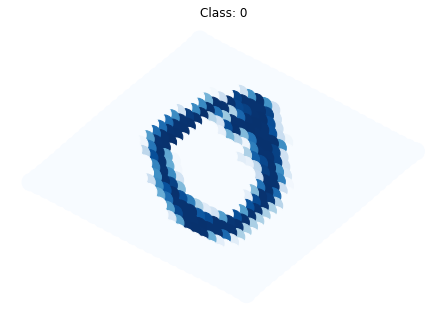

<Figure size 720x216 with 0 Axes>

In [7]:
showGraph(*trainset[random.randrange(10)])

# ChebNetDGL

## Functions for Chebychev Polynoms

In [14]:
def rescale_L(L, lmax=2):
    """
    Rescale the Laplacian eigenvalues in [-1,1]. 
    here implemented for torch
    """
    M, M = L.shape
    I = torch.eye(M)
    L = L/(lmax / 2)
    L -= I
    return L

def chebyshev(L, X, K):
    """Return T_k X where T_k are the Chebyshev polynomials of order up to K.
    Complexity is O(KMN).
    Here implemented for torch
    Change to sparse torch?
    """
    M, N = X.shape
    assert L.dtype == X.dtype

    # L = rescale_L(L, lmax)
    # Xt = T @ X: MxM @ MxN.
    # Xt_0 = T_0 X = I X = X.
    # Xt_1 = T_1 X = L X.
    # Xt_k = 2 L Xt_k-1 - Xt_k-2.
    
    Xt = torch.empty((K, M, N), dtype = L.dtype)
    
    Xt[0, ...] = X
    if K > 1:
        Xt[1, ...] = torch.mm(L,X)
        for k in range(2, K):
            Xt[k, ...] = 2 * torch.mm(L,Xt[k-1, ...]) - Xt[k-2, ...]
    return Xt



In [15]:
def showChebFilters(graph, label, K):
    '''
    Function to visualise the signal of the handwritten digits over a lattice graph
    '''

    nx_G = graph.to_networkx().to_undirected()
    
    Xt = chebyshev(rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
    graph.to_networkx().to_undirected()).todense()).float()), graph.ndata['h'].view(-1, 1), K)
    
    #Xt = chebyshev(rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
    #graph.to_networkx().to_undirected()).todense()).float()),X[5], K)
    # Kamada-Kawaii layout
    pos = nx.kamada_kawai_layout(nx_G)
    
    plt.suptitle('Class: {:d}'.format(label), fontsize=12)
    plt.subplot(231)
    plt.title('Chebynome order 0')
    nx.draw(nx_G, pos, with_labels=False, cmap=plt.cm.Blues, node_color=Xt[0].view(-1))

    plt.subplot(232)
    plt.title('Chebynome order 1')
    nx.draw(nx_G, pos, with_labels=False, cmap=plt.cm.Blues, node_color=Xt[1].view(-1))

    plt.subplot(233)
    plt.title('Chebynome order 2')
    nx.draw(nx_G, pos, with_labels=False,  cmap=plt.cm.Blues, node_color=Xt[2].view(-1))

    plt.subplot(234)
    plt.title('Chebynome order 3')
    nx.draw(nx_G, pos, with_labels=False,  cmap=plt.cm.Blues, node_color=Xt[3].view(-1))
    plt.subplot(235)
    plt.title('Chebynome order 4')
    nx.draw(nx_G, pos, with_labels=False, cmap=plt.cm.Blues, node_color=Xt[4].view(-1))
    plt.subplot(236)
    plt.title('Chebynome order 5')
    nx.draw(nx_G, pos, with_labels=False,  cmap=plt.cm.Blues, node_color=Xt[5].view(-1))
    plt.show()

/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


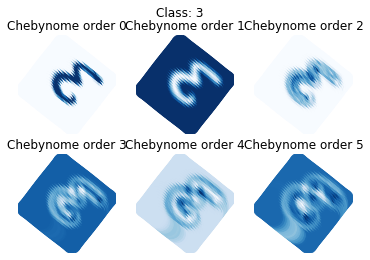

In [16]:
gtest, ltest = trainset[random.randrange(20)]
showChebFilters(gtest, ltest, K=6)

# Model

## Convolution layer
Define a Convolution module that uses this

In [17]:
import dgl.function as fn
import torch
import torch.nn as nn
import torch.nn.functional as F


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')


def reduce(nodes):
    """Take a sum over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.sum(nodes.mailbox['m'], 1)
    return {'h': accum}


class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""

    def __init__(self, in_feats, out_feats, activation, bias=False):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats, bias)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h': h}


class Chebyconv(nn.Module):
    def __init__(self, in_feats, out_feats, k, bias=True):
        super(Chebyconv, self).__init__()
        # Parameters
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        #Convlayer
        self.apply_mod = NodeApplyModule(
            in_feats*k, out_feats, activation=F.relu)
        
        ##
        # NEED TO MAKE A PARAMETER INITIALIZER /!\
        ##

    def forward(self, g, feature):
        # Define Laplacian 
        V, featmaps = feature.size() # Number of verticies, only one Int even if batched, featsmap: number of featuremaps
        self.L = rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
            g.to_networkx().to_undirected()).todense()).float())
        
        Xt = torch.Tensor([])
        #Xt = chebyshev(self.L, feature.view(-1, 1), self._k)
        print('Featuremap size:', feature.size())
        for fmap in range(featmaps): 
            Xt = torch.cat((chebyshev(self.L, feature[:,fmap].view(-1, 1), self._k),Xt) ,0)
            
        print('size of xt', Xt.size())
        g.ndata['h'] = Xt.view(V ,-1)
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

## Convolution layer and classifier


In [18]:
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()
        self.layers = nn.ModuleList([  
            # HARD CODE THIS FOR THE MOMENT
            Chebyconv(in_feats=1, out_feats=32, k=25),
            Chebyconv(in_feats= 32, out_feats=hidden_dim, k=25)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree. 
        h = g.ndata['h'].view(-1,1) # One signal only
        print(g)
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        print('\n size of hg:',hg.size(),'\n')
        return self.classify(hg)

In [19]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

# Debug section

## Batch = 1 Verifying all of the steps

In [20]:
g, l = trainset[0]
L = rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
            g.to_networkx().to_undirected()).todense()).float())

Xt = chebyshev(L, g.ndata['h'].view(-1, 1), 5)  # [k,v,1]

In [21]:
model = Chebyconv(1,32,25)
print(model)
res = model(g,g.ndata['h'].view(-1, 1))
print(res,res.size())

Chebyconv(
  (apply_mod): NodeApplyModule(
    (linear): Linear(in_features=25, out_features=32, bias=False)
  )
)
Featuremap size: torch.Size([784, 1])
size of xt torch.Size([25, 784, 1])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.4237, 0.1102,  ..., 0.2489, 0.0000, 0.0000],
        [0.0000, 0.2116, 0.2090,  ..., 0.3461, 0.0000, 0.0000],
        [0.0000, 0.2349, 0.0822,  ..., 0.2310, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>) torch.Size([784, 32])


In [22]:
res[:,2].size()

torch.Size([784])

In [23]:
g, l = trainset[0]
net = Classifier(1, 64, trainset.num_classes)
print("---------- Network model ----------\n",net)
print("\n ----------  Output for graph g:   ----------\n")
net(g)

---------- Network model ----------
 Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=25, out_features=32, bias=False)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=800, out_features=64, bias=False)
      )
    )
  )
  (classify): Linear(in_features=64, out_features=10, bias=True)
)

 ----------  Output for graph g:   ----------

DGLGraph(num_nodes=784, num_edges=3024,
         ndata_schemes={'h': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})
Featuremap size: torch.Size([784, 1])
size of xt torch.Size([25, 784, 1])
Featuremap size: torch.Size([784, 32])
size of xt torch.Size([800, 784, 1])

 size of hg: torch.Size([64]) 



tensor([ 0.0937, -0.0263,  0.0119,  0.0588, -0.0710,  0.0919, -0.0488,  0.0654,
        -0.0715,  0.0781], grad_fn=<AddBackward0>)

## Batching
Try batching here and look at what happens to the variables.

In [24]:
g,l = collate((trainset[0],trainset[1]))

# What happens with L for several graphs?
L = rescale_L(torch.from_numpy(nx.normalized_laplacian_matrix(
                g.to_networkx().to_undirected()).todense()).float())

# Should the signals be computed separately?
Xt = chebyshev(L, g.ndata['h'].view(-1, 1), 5)  # [k,v,1]

In [25]:
g

DGLGraph(num_nodes=1568, num_edges=6048,
         ndata_schemes={'h': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})

In [26]:
g.ndata['h'].size()

torch.Size([1568])

In [27]:
model = Chebyconv(1,32,25)
print(model)
res = model(g,g.ndata['h'].view(-1, 1))
print(res,res.size())

Chebyconv(
  (apply_mod): NodeApplyModule(
    (linear): Linear(in_features=25, out_features=32, bias=False)
  )
)
Featuremap size: torch.Size([1568, 1])
size of xt torch.Size([25, 1568, 1])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.1044,  ..., 0.0000, 0.0736, 0.0000],
        [0.0000, 0.0435, 0.1503,  ..., 0.0000, 0.5255, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2883, 0.0000]],
       grad_fn=<ReluBackward0>) torch.Size([1568, 32])


# Model definition for training

In [27]:
net = Classifier(1, 64, trainset.num_classes)
print(net)

Classifier(
  (layers): ModuleList(
    (0): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=25, out_features=32, bias=False)
      )
    )
    (1): Chebyconv(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=800, out_features=64, bias=False)
      )
    )
  )
  (classify): Linear(in_features=64, out_features=10, bias=True)
)


# Training pipe

In [28]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=1,
                         shuffle=True, collate_fn=collate)

# Create model
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

## Training time

In [29]:
epoch_losses = []
net.train()
torch.autograd.set_detect_anomaly(True)
for epoch in range(2):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = net(bg).view(1,-1) # This view() will not work when batched
        
        #print("Prediction:", prediction,'len:',prediction.size())
        lossvect=torch.zeros(1, dtype=torch.long)
        lossvect[0] = label # Format: [0,9,2] if the three predictions should be class O, 9 and 2 for three batched graphs
        #print("lossv:", lossvect,'len:',lossvect.size())
        loss = loss_func(prediction, lossvect)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

DGLGraph(num_nodes=784, num_edges=3024,
         ndata_schemes={'h': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})
Featuremap size: torch.Size([784, 1])
size of xt torch.Size([25, 784, 1])
Featuremap size: torch.Size([784, 32])
size of xt torch.Size([800, 784, 1])

 size of hg: torch.Size([1, 64]) 



/Users/distiller/project/conda/conda-bld/pytorch_1565272526878/work/torch/csrc/autograd/python_anomaly_mode.cpp:57: UserWarning: Traceback of forward call that caused the error:
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/Users/axel/miniconda3/envs/DGL/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  F

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [784, 1]], which is output 0 of SelectBackward, is at version 25; expected version 24 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

## Test Metrics

In [16]:
net.eval()
data_loader_test = DataLoader(testset, batch_size=1,
                              shuffle=False, collate_fn=collate)
loss = 0
preds = []
test = 0
for iter, (bg, label) in enumerate(data_loader):
    prediction = net(bg, bg.ndata['h'])
    preds.append(prediction)
    test = prediction
    loss = loss_func(prediction.view(1,-1), label)
    
    loss += loss
print('Total Loss {:.4f}'.format(loss*100))

Total Loss 0.0086


In [17]:
from sklearn.metrics import classification_report



In [19]:
prediction

tensor([  0.1006, -25.5242, -14.9417,  -5.1505, -13.4526,  -7.2645, -13.7934,
         10.1673, -10.5867,  -5.1622], grad_fn=<AddBackward0>)

In [23]:
probs = torch.softmax(prediction.view(-1,1)).detach().numpy()
pred_y = np.argmax(probs,1)

TypeError: softmax() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, name dim, torch.dtype dtype)
 * (Tensor input, int dim, torch.dtype dtype)


In [ ]:
net.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
#test_bg = dgl.batch(test_X)


test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(net(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)


print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))

# GCN

# Other Shit

In [39]:
def graph_conv_cheby(self, x, cl, L, lmax, Fout, K):

        # parameters
        # B = batch size
        # V = nb vertices
        # Fin = nb input features
        # Fout = nb output features
        # K = Chebyshev order & support size
        B, V, Fin = x.size()
        B, V, Fin = int(B), int(V), int(Fin)

        # rescale Laplacian
        lmax = lmax_L(L)
        L = rescale_L(L, lmax)

        # convert scipy sparse matric L to pytorch
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col)).T
        indices = indices.astype(np.int64)
        indices = torch.from_numpy(indices)
        indices = indices.type(torch.LongTensor)

        L_data = L.data.astype(np.float32)
        L_data = torch.from_numpy(L_data)
        L_data = L_data.type(torch.FloatTensor)

        L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
        L = Variable(L, requires_grad=False)
        if torch.cuda.is_available():
            L = L.cuda()

        # transform to Chebyshev basis
        x0 = x.permute(1, 2, 0).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])            # V x Fin*B
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B

        def concat(x, x_):
            x_ = x_.unsqueeze(0)            # 1 x V x Fin*B
            return torch.cat((x, x_), 0)    # K x V x Fin*B

        if K > 1:
            x1 = my_sparse_mm.apply(L, x0)              # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)), 0)  # 2 x V x Fin*B
        for k in range(2, K):
            x2 = 2 * my_sparse_mm.apply(L, x1) - x0
            x = torch.cat((x, x2.unsqueeze(0)), 0)  # M x Fin*B
            x0, x1 = x1, x2

        x = x.view([K, V, Fin, B])           # K x V x Fin x B
        x = x.permute(3, 1, 2, 0).contiguous()  # B x V x Fin x K
        x = x.view([B*V, Fin*K])             # B*V x Fin*K

        # Compose linearly Fin features to get Fout features
        x = cl(x)                            # B*V x Fout
        x = x.view([B, V, Fout])             # B x V x Fout

        return x


Chebyshev Spectral Graph Convolution layer from paper Convolutional
    Neural Networks on Graphs with Fast Localized Spectral Filtering
    <https://arxiv.org/pdf/1606.09375.pdf>

$h_i^{l+1}$ &= $\sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}$

$Z^{0, l}$ &= $H^{l}$

$Z^{1, l}$ &=$ \hat{L} \cdot H^{l}$

$Z^{k, l}$ &= $2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}$

$\hat{L}$ &= $2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I$

    Parameters
    ----------
    in_feats: int
        Number of input features.
    out_feats: int
        Number of output features.
    k : int
        Chebyshev filter size.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.